# INM430 Coursework Final Submission Part-2 - Analysis Files

## Table of Contents
1. [Setup](#setup)
2. [Loading the Data](#loading-the-data)
3. [Data Exploration](#data-exploration)
4. [Baseline Model](#baseline-model)
5. [TF-IDF Representation](#tf-idf-representation)
6. [Doc2Vec Representation](#doc2vec-representation)
7. [Evaluation](#evaluation)

<a name="setup"></a>
## 1. Setup

Hide errors for presentation purposes

In [1]:
import warnings
warnings.filterwarnings('ignore')

Import dependencies

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import multiprocessing
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from pipelinehelper import PipelineHelper
import re
import seaborn as sns
from sklearn import utils
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline

<a name="loading-the-data"></a>
## 2. Loading the Data

Due to some parsing errors with the web scraper, some lyrics were not returned to appear as empty strings or null values in the CSV file.

In [3]:
tracks_by_artist = pd.read_csv("./data/tracks_with_lyrics_for_top_10_artists.csv")
tracks_by_artist = tracks_by_artist[~tracks_by_artist["lyrics"].isnull()]

In [4]:
tracks_by_artist.head()

,artist,album,track,lyrics
0,T.I.,Trap Muzik,I Can't Quit,"[Intro]\nHuh, hell nah, I can't quit\nHell nah..."
1,T.I.,Trap Muzik,Be Easy,"[Intro]\nUh-uh, uh-uh, uh\nAye, where the pian..."
2,T.I.,Trap Muzik,No More Talk,[Verse 1]\nI'm either running for my life or I...
3,T.I.,Trap Muzik,Doin My Job,"[T.I. - talking]\nAy I'm working here, know wh..."
4,T.I.,Trap Muzik,24's,"[Intro]\nYeah\nFor all my real ATL niggas, tha..."


In [5]:
tracks_by_artist.shape

(679, 4)

Have a total of 679 tracks with lyrics with artist name and album title as additional metadata

<a name="data-exploration"></a>
## 3. Data Exploration

The following illustrates the break down of the number of tracks by artist considered in this project. This has implications for the evaluation metrics I will report in the investigation. The following considerations are important to decide the evaluation metrics,

* The project deals with a supervised, multiclass classification task,
* The classes in the original dataset are unbalanced.

For these reasons, I will report the precision, recall, and fscore for each model.

Text(0.5,1,'Total Number of Tracks with Lyrics by Artist')

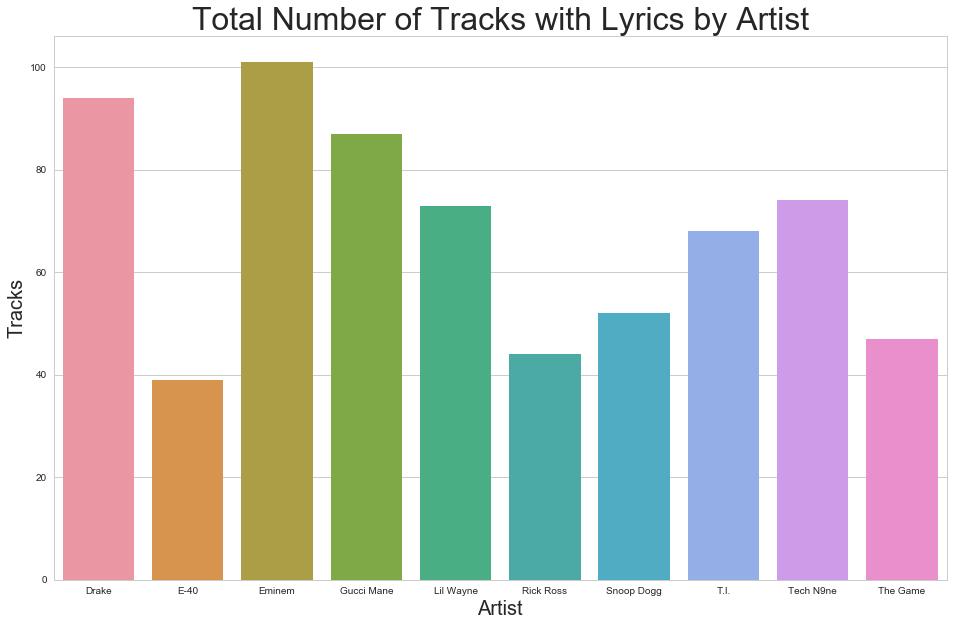

In [6]:
total_tracks_by_artist = tracks_by_artist.groupby("artist").agg("count")[["track"]]
total_tracks_by_artist = total_tracks_by_artist.reset_index()
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(ax=ax, x="artist", y="track", data=total_tracks_by_artist)
ax.set_xlabel("Artist", fontsize=20)
ax.set_ylabel("Tracks", fontsize=20)
ax.set_title("Total Number of Tracks with Lyrics by Artist", fontsize=32)

Same as above but with numbers

In [7]:
tracks_by_artist.groupby("artist")["track"].agg("count")

artist
Drake          94
E-40           39
Eminem        101
Gucci Mane     87
Lil Wayne      73
Rick Ross      44
Snoop Dogg     52
T.I.           68
Tech N9ne      74
The Game       47
Name: track, dtype: int64

<a name="baseline-model"></a>
## 4. Baseline Model

For a like to like comparison with future text representations and models, this section reports on the testing results of a logistic regression classifier using a Bag-of-Words representation. This is very basic but will help indicate whether choices for later models help to improve on the overall classification task.

In [8]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34)
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [9]:
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train["lyrics"])
X_test_bow = bow.transform(X_test["lyrics"])

Perform grid search cross-validation to find the optimal value for the C parameter. The predictions are generated from the model with this value for C.

In [10]:
param_grid = {"C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}

logreg = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid)
logreg.fit(X_train_bow, y_train.ravel())
y_pred = logreg.predict(X_test_bow)

prfs = precision_recall_fscore_support(y_test.ravel(), y_pred, average='weighted', labels=np.unique(y_pred))

Reported results for baseline model.

In [11]:
print('Testing Precision: {}'.format(prfs[0]))
print('Testing Recall: {}'.format(prfs[1]))
print('Testing FScore: {}'.format(prfs[2]))
print("Logistic Regression Param C: {}".format(logreg.best_params_["C"]))

Testing Precision: 0.7048856553990449
Testing Recall: 0.6862745098039216
Testing FScore: 0.686845629812127
Logistic Regression Param C: 100.0


<a name="tf-idf-representation"></a>
## 5. TF-IDF Representation

Models to be considered,

* Logistic Regression 
* Linear SVM
* Naive Bayes

In [12]:
# Helper functions

def best_results_by_model(grid_scores):
    
    best_results_by_model = {}
    for score in grid_scores:
        model_name = score[0]["classifier__selected_model"][0]
        if (model_name not in best_results_by_model) or (score[1] > best_results_by_model[model_name]["mean"]):
            best_results_by_model[model_name] = {
                "params": score[0],
                "mean": score[1],
                "results": score[2],
            }
    
    return best_results_by_model   

### Feature engineering

The features I will be considering in this project are,

* Encoded track lyrics: I will con. This will be the main variable in the project
* Track line count: the total number of lines in each track, breaking on newline characters "\n"
* Average line length: the number of words 
* Unique word proportion: the proportion of unique words out of the total number of words in a given track
* ...

These are all generated from the raw lyrics from the data collection process

### TF-IDF 

In [13]:
# Custom Transformers

class LyricsExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].values
    
class VectorExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["vectors"].values

class LineCountExtractor(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].str.split("\n").apply(len)

class AverageLineLengthExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].str.split("\n").apply(lambda lines: sum(map(len,lines))/len(lines))

class UniqueWordProportionExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].apply(lambda lyrics: self.__prop_unique_words(lyrics))
    
    def __prop_unique_words(self, lyrics):
        return self.__get_unique_word_count(lyrics) / self.__get_total_word_count(lyrics)
    
    def __get_total_word_count(self, lyrics):
        return len(re.split(" |\n|", lyrics))
    
    def __get_unique_word_count(self, lyrics):
        return len(set(re.split(" |\n|", lyrics)))

class ArrayCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return np.transpose(np.matrix(data))
    
class ListCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.tolist()

In [14]:
# Pipelines
song_vectors = Pipeline([
                ("lyrics", LyricsExtractor()),
                ("tfidf", TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, tokenizer=word_tokenize)),
            ])

line_count = Pipeline([
                ("get_line_count", LineCountExtractor()),
                ("caster", ArrayCaster())
            ])

average_line_length = Pipeline([
                ("get_average_line_length", AverageLineLengthExtractor()),
                ("caster", ArrayCaster())
            ])

unique_word_proportion = Pipeline([
                ("get_unique_word_proportion", UniqueWordProportionExtractor()),
                ("caster", ArrayCaster())
            ])

# other features go here ...

In [15]:
featureunion = FeatureUnion([
    ("line_count", line_count),
    ("song_vectors", song_vectors),
    ("average_line_length", average_line_length),
    ("unique_word_proportion", unique_word_proportion)
])

In [16]:
pipeline = Pipeline([
    ("featureunion", featureunion),
    ("classifier", PipelineHelper([
        ("MultinomialNB", MultinomialNB()),
        ("LogisticRegression", LogisticRegression()),
        ("LinearSVC", LinearSVC())
    ]))
])

In [21]:
param_grid = {
    "featureunion__transformer_weights": [
        # one feature only
        {"song_vectors":0,"line_count":0, "average_line_length":0, "unique_word_proportion":1},#0001
        {"song_vectors":0,"line_count":0, "average_line_length":1, "unique_word_proportion":0},#0010
        {"song_vectors":0,"line_count":1, "average_line_length":0, "unique_word_proportion":0},#0100
        {"song_vectors":1,"line_count":0, "average_line_length":0, "unique_word_proportion":0},#1000
        
        # two features
        {"song_vectors":0,"line_count":0, "average_line_length":1, "unique_word_proportion":1},#0011
        {"song_vectors":0,"line_count":1, "average_line_length":0, "unique_word_proportion":1},#0101
        {"song_vectors":0,"line_count":1, "average_line_length":1, "unique_word_proportion":0},#0110
        {"song_vectors":1,"line_count":0, "average_line_length":0, "unique_word_proportion":1},#1001
        {"song_vectors":1,"line_count":0, "average_line_length":1, "unique_word_proportion":0},#1010
        {"song_vectors":1,"line_count":1, "average_line_length":0, "unique_word_proportion":0},#1100
        
        # three features
        {"song_vectors":0,"line_count":1, "average_line_length":1, "unique_word_proportion":1},#0111
        {"song_vectors":1,"line_count":0, "average_line_length":1, "unique_word_proportion":1},#1011
        {"song_vectors":1,"line_count":1, "average_line_length":0, "unique_word_proportion":1},#1101
        {"song_vectors":1,"line_count":1, "average_line_length":1, "unique_word_proportion":0},#1110
        
        # all features
        {"song_vectors":1,"line_count":1, "average_line_length": 1, "unique_word_proportion": 1},#1111
    ],
    # need to put range of classifiers here
    "classifier__selected_model": pipeline.named_steps["classifier"].generate({
        "LogisticRegression__C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
    })
}

In [22]:
gs_clf = GridSearchCV(pipeline, param_grid, cv=5)

In [23]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34)
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [24]:
gs_clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [40]:
best_results_by_model(gs_clf.grid_scores_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'LinearSVC': {'mean': 0.7978947368421052,
  'params': {'classifier__selected_model': ('LinearSVC', {}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.75757576, 0.80808081, 0.85263158, 0.82795699, 0.74157303])},
 'LogisticRegression': {'mean': 0.8063157894736842,
  'params': {'classifier__selected_model': ('LogisticRegression',
    {'C': 1000000.0}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.76767677, 0.80808081, 0.85263158, 0.86021505, 0.74157303])},
 'MultinomialNB': {'mean': 0.3705263157894737,
  'params': {'classifier__selected_model': ('MultinomialNB', {}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.35353535, 0.363

In [41]:
y_pred = gs_clf.predict(X_test)

print('Testing Precision: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print('Testing Recall: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))
print('Testing FScore: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))

Testing Precision: 0.7885708433502551
Testing Recall: 0.7892156862745098
Testing FScore: 0.7835318407910754


/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


<a name="doc2vec-representation"></a>
## 6. Doc2Vec Representation

In [25]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34)
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [26]:
train_tagged = [TaggedDocument(words=word_tokenize(X_train["lyrics"].tolist()[idx]), tags=y_train.tolist()[idx]) for idx, _ in enumerate(y_train)]
test_tagged = [TaggedDocument(words=word_tokenize(X_test["lyrics"].tolist()[idx]), tags=y_test.tolist()[idx]) for idx, _ in enumerate(y_test)]

In [27]:
model_dbow = Doc2Vec(dm=0, vector_size=3000, sample=0, workers=multiprocessing.cpu_count())
model_dbow.build_vocab(train_tagged)

In [29]:
max_epochs = 30
for epoch in range(max_epochs):
    model_dbow.train(utils.shuffle(train_tagged), total_examples=model_dbow.corpus_count, epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [30]:
def vec_for_learning(model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in tagged_docs])
    return targets, regressors

In [31]:
y_train, X_train["vectors"] = vec_for_learning(model_dbow, train_tagged)
y_test, X_test["vectors"] = vec_for_learning(model_dbow, test_tagged)

In [32]:
class ListCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.tolist()

song_vectors = Pipeline([
                ("vector", VectorExtractor()),
                ("tolist", ListCaster()),
            ])

In [33]:
doc2vec_gs_clf = GridSearchCV(pipeline, param_grid, cv=5)

In [34]:
doc2vec_gs_clf.fit(X_train, list(y_train))

KeyboardInterrupt: 

In [53]:
best_results_by_model(doc2vec_gs_clf.grid_scores_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'LinearSVC': {'mean': 0.3410526315789474,
  'params': {'classifier__selected_model': ('LinearSVC', {})},
  'results': array([0.4040404 , 0.10309278, 0.36170213, 0.55913978, 0.2826087 ])},
 'LogisticRegression': {'mean': 0.7810526315789473,
  'params': {'classifier__selected_model': ('LogisticRegression',
    {'C': 1000000.0})},
  'results': array([0.81818182, 0.79381443, 0.80851064, 0.76344086, 0.7173913 ])},
 'MultinomialNB': {'mean': 0.27578947368421053,
  'params': {'classifier__selected_model': ('MultinomialNB', {})},
  'results': array([0.27272727, 0.26804124, 0.27659574, 0.27956989, 0.2826087 ])}}

In [56]:
y_pred = doc2vec_gs_clf.predict(X_test)

print('Testing Precision: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print('Testing Recall: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))
print('Testing FScore: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))

Testing Precision: 0.7772407784662686
Testing Recall: 0.7745098039215687
Testing FScore: 0.7676336690053341


<a name="evaluation"></a>
## 7. Evaluation